In [15]:
from canada_data import *

import numpy as np
import pandas as pd
import scipy.stats as st


In [16]:
bg_dd_df, sec_df = get_bg_dd_data(fillinf=False)
dd_df, _ = get_dd_data()
macro_df = get_macro_data()
sector_bg_dd = get_sector_bg_dd()

In [20]:
macro_df.query("Dates > '2009-05'")

GDP       CPI       Emp
Dates                                
2009-06 -4.158578 -0.174064 -2.768903
2009-07 -4.417735 -0.953206 -2.768903
2009-08 -4.381858 -0.779896 -2.662407
2009-09 -3.683591 -0.779221 -2.449414
2009-10 -3.475635  0.087184 -2.452026
...           ...       ...       ...
2019-10  1.435369  1.862891  0.318810
2019-11  1.653641  2.089552 -0.212089
2019-12  1.961175  2.233805  0.106157
2020-01  1.902513  2.233805  0.318810
2020-02  2.399883  2.078693  0.212540

[129 rows x 3 columns]

In [93]:
sec_df.reset_index().groupby('Level 1').count()

Ticker
Level 1        
11            4
21          272
22           26
23            4
31          154
42           19
44           24
48           31
51           60
52           55
53           44
54           12
56            6
62            5
71            5
72            6
81            1

In [3]:
pairs = []
n_group = 5
for d in bg_dd_df.index:
    for tk in bg_dd_df.columns:
        pairs.append([
                dd_df.at[d, tk],
                bg_dd_df.at[d, tk],
                macro_df.at[d, 'GDP'],
                macro_df.at[d, 'CPI'],
                macro_df.at[d, 'Emp'],
                reg_df.at[d, 'Regs'],
            ])
pairs = np.array(pairs)
pairs = pairs[~np.any(np.isnan(pairs), axis=1),:]
pairs = pd.DataFrame(pairs, columns=['DD', 'BGDD', 'GDP', 'CPI', 'Emp', 'Regs'])

In [4]:
import matplotlib.pyplot as plt
df = pairs.assign(g_group = pd.qcut(pairs.GDP, 5, labels=False))
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(14, 15))
for i in range(3):
    for j in range(4):
        obs = df.query(f"Regs=={i} and g_group=={j}")
        obs.plot.scatter('DD', 'BGDD', alpha=0.1, ax=axs[i, j])
        axs[i, j].set(xlim=[-10, 50], ylim=[0,7], title=f"Regime {i}, GDP group {j}")
        axs[i, j].grid()

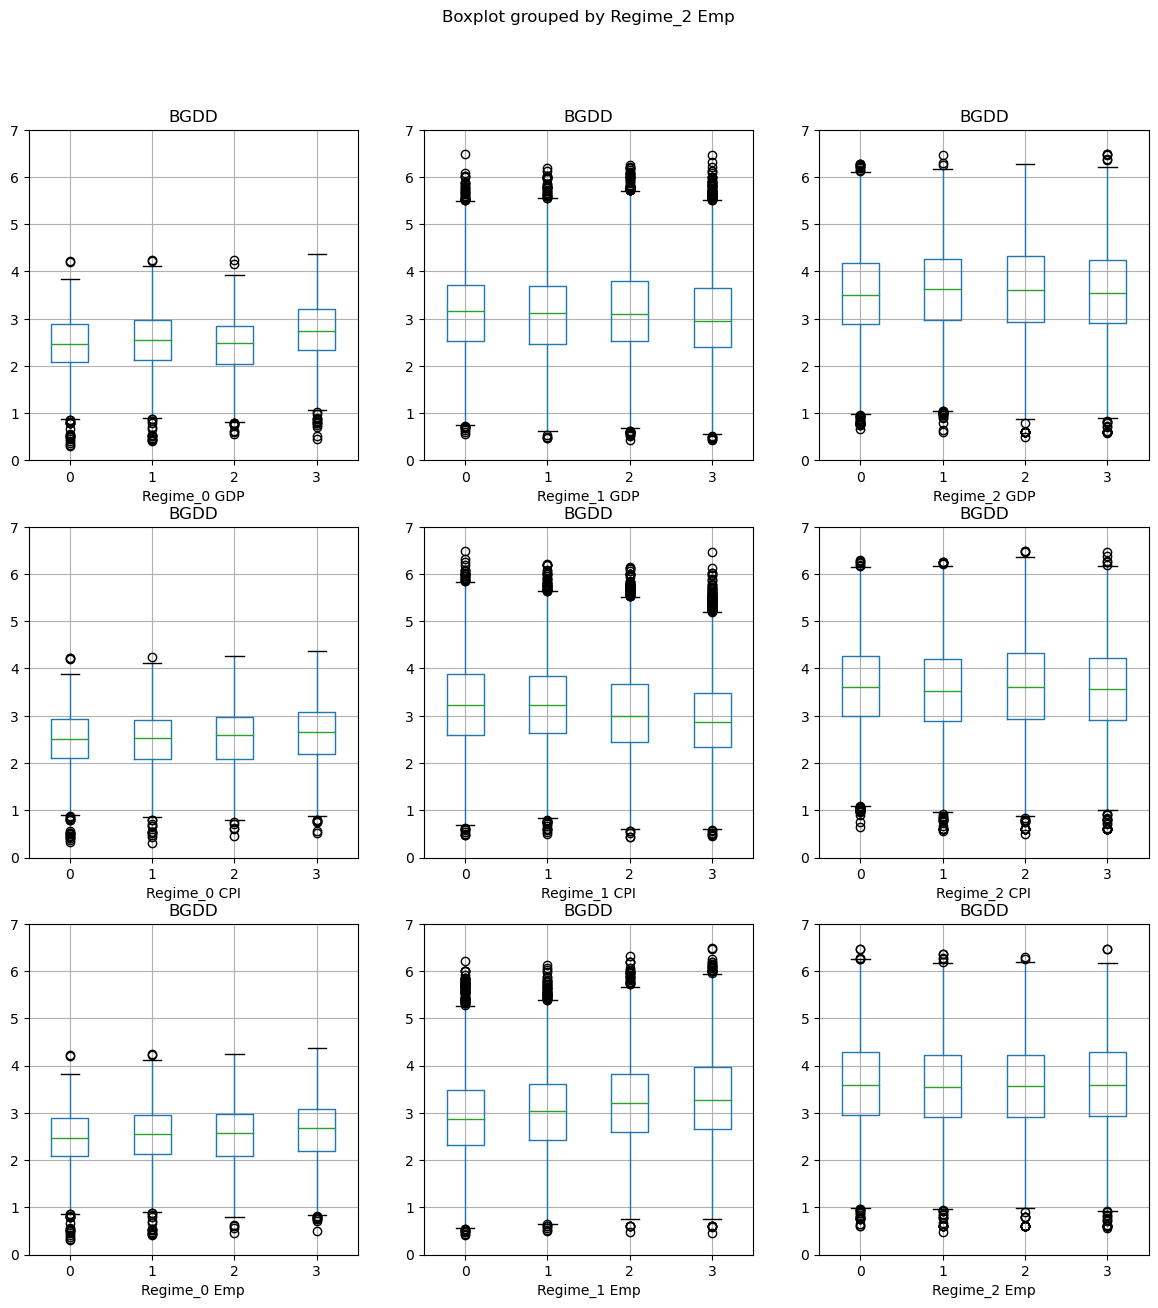

In [6]:
import matplotlib.pyplot as plt
var = 'Emp'
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(14, 15))
for i, var in enumerate(['GDP', 'CPI', 'Emp']):
    for j in range(3):
        obs = pairs.query(f"Regs=={j}")
        obs = obs.assign(**{f"Regime_{j} {var}": pd.qcut(obs.loc[:, var], 4, labels=False)})
        obs.boxplot(column='BGDD', by=f"Regime_{j} {var}", ax=axs[i,j])
        axs[i,j].set(ylim=[0,7])

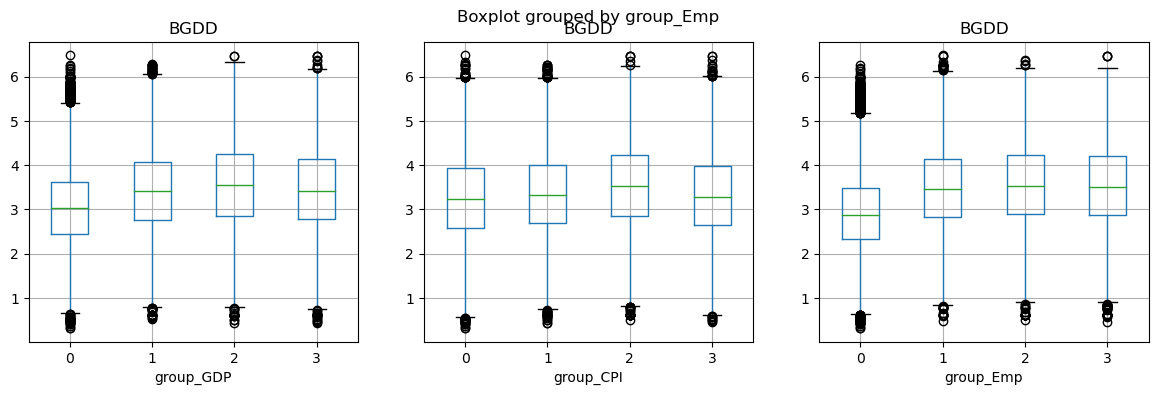

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))
for i, var in enumerate(['GDP', 'CPI', 'Emp']):
    obs = pairs.assign(**{'group_'+var: pd.qcut(pairs.loc[:, var], 4, labels=False)})
    obs.boxplot(column='BGDD', by='group_'+var, ax=axs[i])

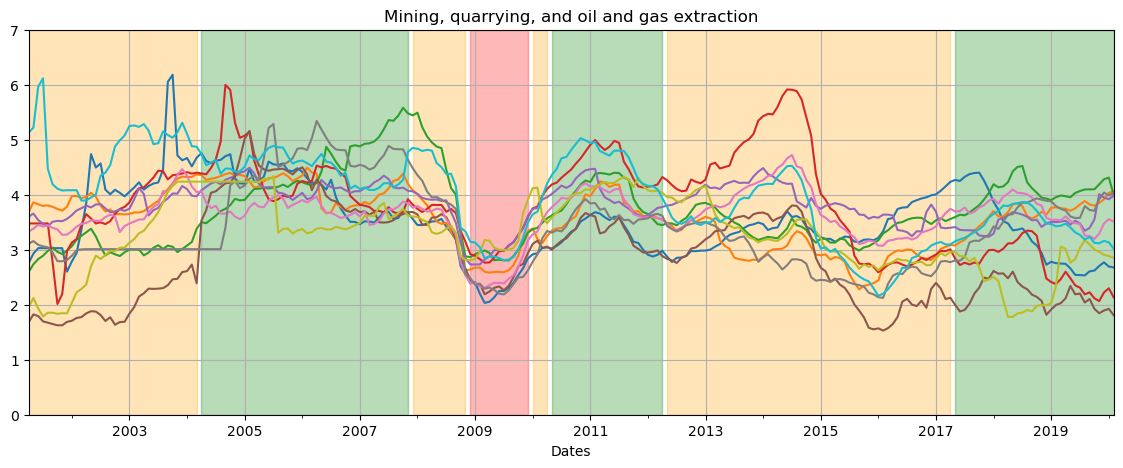

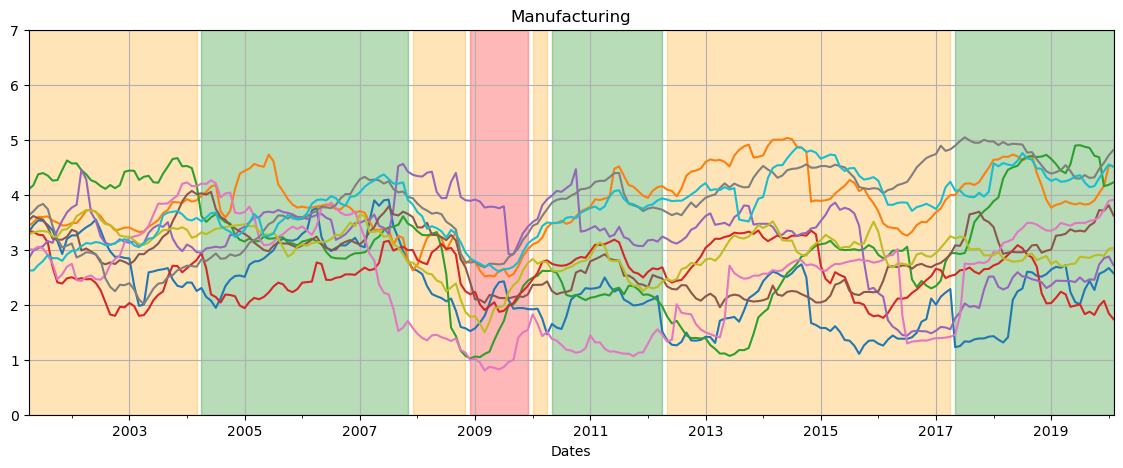

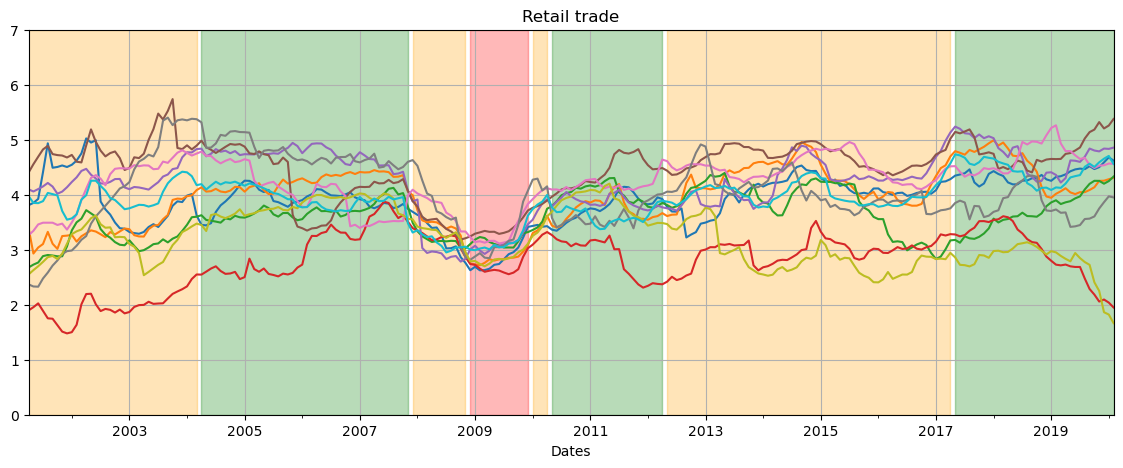

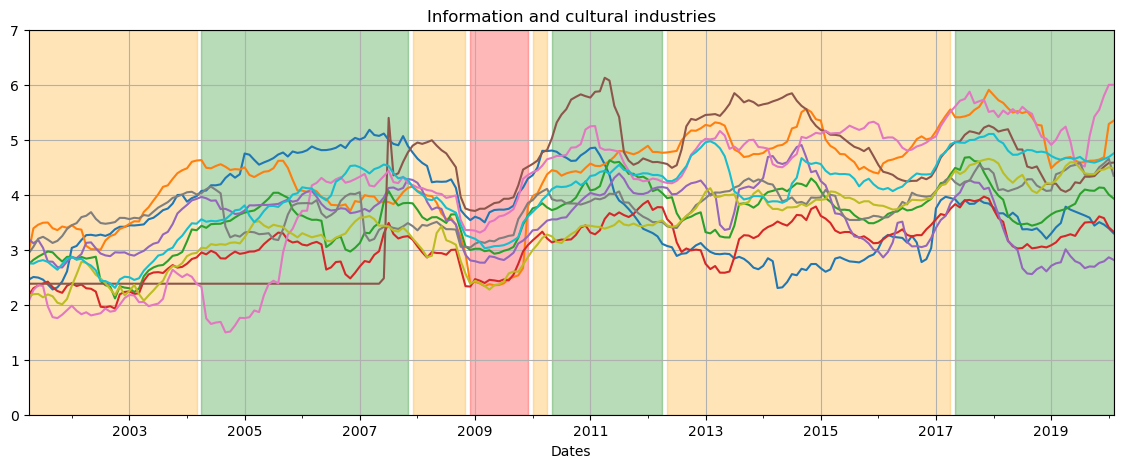

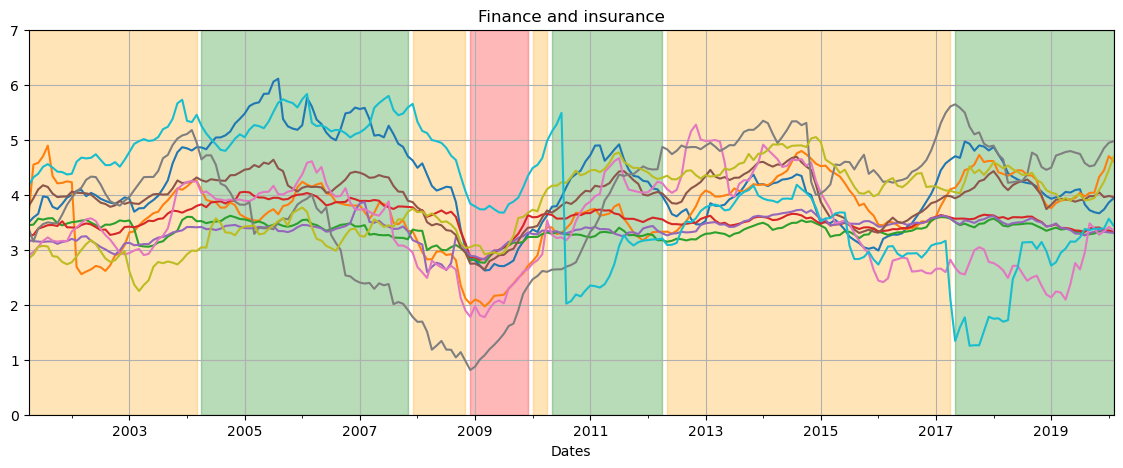

In [26]:
sectors = {
    21: 'Mining, quarrying, and oil and gas extraction',
    31: 'Manufacturing',
    44: 'Retail trade',
    51: 'Information and cultural industries',
    52: 'Finance and insurance'
}
df = bg_dd_df.dropna(axis=1, how='any')
sdf = sec_df.loc[df.columns]

for s, name in sectors.items():
    fig, ax = plt.subplots(figsize=(14, 5))
    temp = df.loc[:,sdf[sdf['Level 1']==s].index].iloc[:,:10]
    temp.plot(figsize=(14,5), ylim=[0,7], legend=False, title=name, ax=ax)
    ax.grid()
    for j in range(3):
        ax.fill_between(reg_df.index, 0, 7, where=reg_df.Regs==0, alpha=0.1, color='r')
        ax.fill_between(reg_df.index, 0, 7, where=reg_df.Regs==1, alpha=0.1, color='orange')
        ax.fill_between(reg_df.index, 0, 7, where=reg_df.Regs==2, alpha=0.1, color='green')


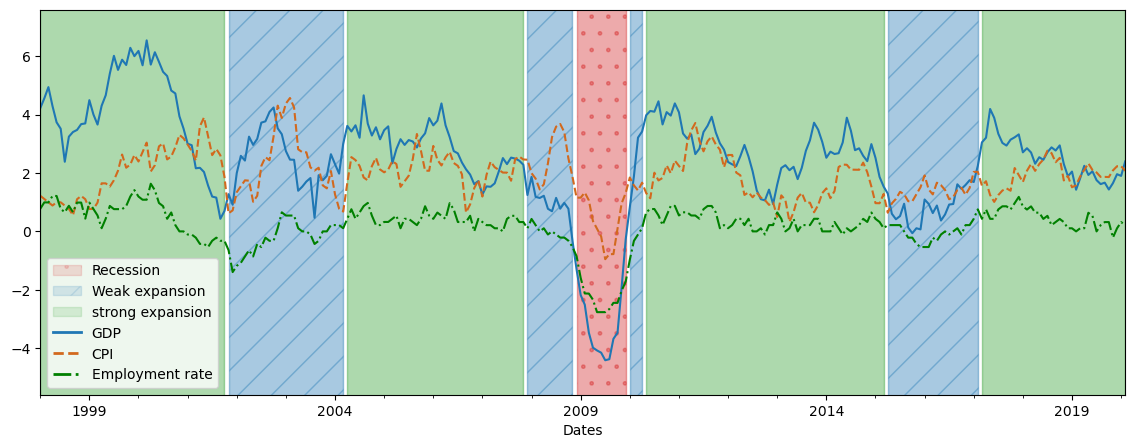

In [6]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
fig, ax = plt.subplots(figsize=(14,5))
macro_df.columns = ['GDP', 'CPI', 'Employment rate']
style = ['-','--','-.']
color = ["tab:blue", "chocolate", "green"]
macro_df.plot(ax=ax, style=style, color=color)
legend_lines = [
    mlines.Line2D([], [], color=color[i], linestyle=style[i], linewidth=2) for i in range(3)
]
for j in range(3):
    f0 = ax.fill_between(reg_df.index, -5, 7, where=reg_df.Regs==0, alpha=0.15, color='tab:red', transform=ax.get_xaxis_transform(), hatch='.')
    f1 = ax.fill_between(reg_df.index, -5, 7, where=reg_df.Regs==1, alpha=0.15, color='tab:blue', transform=ax.get_xaxis_transform(), hatch='/')
    f2 = ax.fill_between(reg_df.index, -5, 7, where=reg_df.Regs==2, alpha=0.15, color='tab:green', transform=ax.get_xaxis_transform())
ax.legend(handles=[f0, f1, f2]+legend_lines, labels=['Recession','Weak expansion','strong expansion','GDP', 'CPI', 'Employment rate'])
fig.savefig('simulation_plots/canada_regimes.pdf')

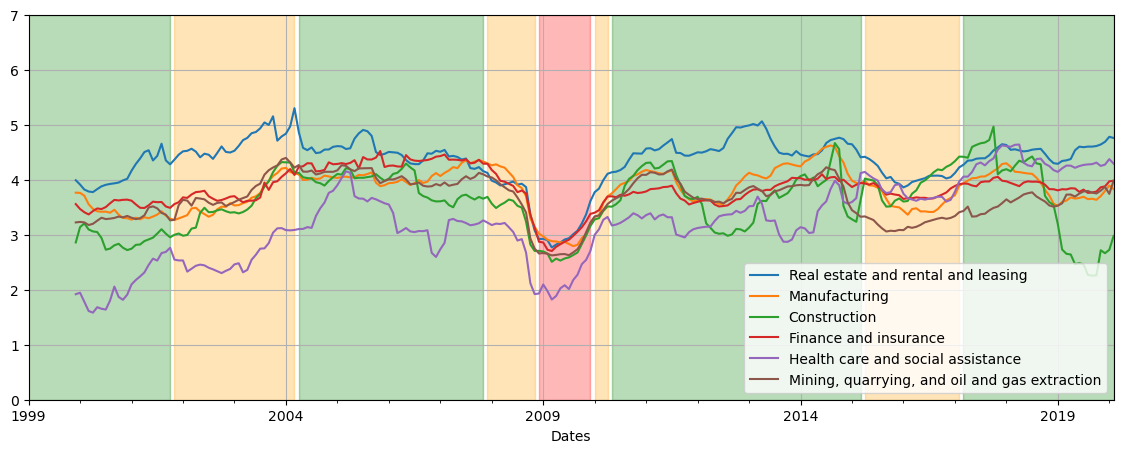

In [50]:
import matplotlib.pyplot as plt
sectors = {
    53: 'Real estate and rental and leasing',
    31: 'Manufacturing',
    23: 'Construction',
    52: 'Finance and insurance',
    62: 'Health care and social assistance',
    21: 'Mining, quarrying, and oil and gas extraction'
}
temp_df = sector_bg_dd.loc[:, list(sectors.keys())]
temp_df.rename(columns=sectors, inplace=True)
fig, ax = plt.subplots(figsize=(14, 5))
temp_df.plot(figsize=(14,5), ylim=[0,7], legend=True, ax=ax)
ax.grid()
for j in range(3):
    ax.fill_between(reg_df.index, 0, 7, where=reg_df.Regs==0, alpha=0.1, color='r')
    ax.fill_between(reg_df.index, 0, 7, where=reg_df.Regs==1, alpha=0.1, color='orange')
    ax.fill_between(reg_df.index, 0, 7, where=reg_df.Regs==2, alpha=0.1, color='green')

In [31]:
start_date='19980101'
end_date='20200229'
freq='M'

bg_dd_df, sec_df = get_bg_dd_data(fillinf=False, freq=freq)
dd_df = bg_dd_df

In [32]:
dd_df.index

DatetimeIndex(['1999-01-31', '1999-02-28', '1999-03-31', '1999-04-30',
               '1999-05-31', '1999-06-30', '1999-07-31', '1999-08-31',
               '1999-09-30', '1999-10-31',
               ...
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31',
               '2020-01-31', '2020-02-29'],
              dtype='datetime64[ns]', name='Dates', length=254, freq='M')

In [44]:
    bg_dd_df, sec_df = get_bg_dd_data(fillinf=False, freq=freq)
    dd_df = bg_dd_df

    mkc_df = mkt.get_stk('MktC', index_date=True).sort_index()
    mkc_df = mkc_df.query(f"(Dates >= '{start_date}') and (Dates <= '{end_date}')")
    mkc_df = mkc_df.resample(freq).mean()

    stock_list = mkt.get_acc_hist_m('20200219').index.to_list()

    all_data = []
    for m in dd_df.index:
        df1 = dd_df.loc[m, :].dropna()
        df2 = mkc_df.loc[m, :].dropna()
        union_stocks = list(set(df1.index).intersection(df2.index))
        union_stocks = list(set(stock_list).intersection(union_stocks))
        temp_sec_df = sec_df.loc[union_stocks, :]
        row_values = []
        for i in np.unique(sec_df):
            stocks = temp_sec_df.loc[temp_sec_df['Level 1']==i,:].index
            if (demo := df2.loc[stocks].sum()) == 0:
                row_values.append(np.nan)
            else:
                row_values.append((df1.loc[stocks] * df2.loc[stocks]).sum() / demo)
        all_data.append(row_values)
    sector_dd_df = pd.DataFrame(all_data, index=dd_df.index, columns=np.unique(sec_df))

In [78]:
    mkc_df = mkt.get_stk('MktC', index_date=True).sort_index()
    mkc_df = mkc_df.query(f"(Dates >= '{start_date}') and (Dates <= '{end_date}')")
    mkc_df = mkc_df.resample(freq).mean()

In [96]:
dd_df

Ticker      0112977D CT Equity  0132533D CT Equity  0206904D CT Equity  \
Dates                                                                    
1999-01-31                 NaN                 NaN                 NaN   
1999-02-28                 NaN                 NaN                 NaN   
1999-03-31                 NaN                 NaN                 NaN   
1999-04-30                 NaN                 NaN                 NaN   
1999-05-31                 NaN                 NaN                 NaN   
...                        ...                 ...                 ...   
2019-10-31                 NaN                 NaN                 NaN   
2019-11-30                 NaN                 NaN                 NaN   
2019-12-31                 NaN                 NaN                 NaN   
2020-01-31                 NaN                 NaN                 NaN   
2020-02-29                 NaN                 NaN                 NaN   

Ticker      0212714D CT Equity  0227217Q CT Equity  0334249Q CT Equity  \
Dates                                                                    
1999-01-31                 NaN                 NaN                 NaN   
1999-02-28                 NaN                 NaN                 NaN   
1999-03-31                 NaN                 NaN                 NaN   
1999-04-30                 NaN                 NaN                 NaN   
1999-05-31                 NaN                 NaN                 NaN   
...                        ...                 ...                 ...   
2019-10-31                 NaN                 NaN                 NaN   
2019-11-30                 NaN                 NaN                 NaN   
2019-12-31                 NaN                 NaN                 NaN   
2020-01-31                 NaN                 NaN                 NaN   
2020-02-29                 NaN                 NaN                 NaN   

Ticker      0339293Q CT Equity  0365557D CT Equity  0569091D CT Equity  \
Dates                                                                    
1999-01-31                 NaN                 NaN                 NaN   
1999-02-28                 NaN                 NaN                 NaN   
1999-03-31                 NaN                 NaN                 NaN   
1999-04-30                 NaN                 NaN                 NaN   
1999-05-31                 NaN                 NaN                 NaN   
...                        ...                 ...                 ...   
2019-10-31                 NaN                 NaN                 NaN   
2019-11-30                 NaN                 NaN                 NaN   
2019-12-31                 NaN                 NaN                 NaN   
2020-01-31                 NaN                 NaN                 NaN   
2020-02-29                 NaN                 NaN                 NaN   

Ticker      0600326D CN Equity  ...  WTE CT Equity  WTN CT Equity  \
Dates                           ...                                 
1999-01-31                 NaN  ...            NaN            NaN   
1999-02-28                 NaN  ...            NaN            NaN   
1999-03-31                 NaN  ...            NaN            NaN   
1999-04-30                 NaN  ...            NaN            NaN   
1999-05-31                 NaN  ...            NaN            NaN   
...                        ...  ...            ...            ...   
2019-10-31                 NaN  ...       3.759665            NaN   
2019-11-30                 NaN  ...       3.787358            NaN   
2019-12-31                 NaN  ...       3.686517            NaN   
2020-01-31                 NaN  ...       3.584159            NaN   
2020-02-29                 NaN  ...       3.452979            NaN   

Ticker      WTO CT Equity  X CT Equity  XG CT Equity  YLO CT Equity  \
Dates                                                                 
1999-01-31            NaN          NaN           NaN            NaN   


In [107]:
for s in sectors.keys():
    mkc_temp_df = mkc_df.iloc[-1,:]
    mkc_temp_df.name = 'mkc'
    dd_temp_df = dd_df.iloc[-1,:]
    dd_temp_df.name = 'dd'
    df = sec_df.join(mkc_temp_df).dropna()
    df = df.join(dd_temp_df).dropna()
    df = df.loc[df['Level 1']==s,:]
    df = df.sort_values(by='mkc', ascending=False)
    df.columns = ['Sector', 'Market capitalization', 'Distance to default']
    print(df.iloc[:,1:].round(2).head().to_latex())

\begin{tabular}{lrr}
\toprule
 & Market capitalization & Distance to default \\
Ticker &  &  \\
\midrule
BPY-U CT Equity & 24281.330000 & 3.270000 \\
CHP-U CT Equity & 10235.180000 & 5.520000 \\
CAR-U CT Equity & 9837.200000 & 5.170000 \\
REI-U CT Equity & 8545.740000 & 5.880000 \\
AP-U CT Equity & 7082.480000 & 5.640000 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrr}
\toprule
 & Market capitalization & Distance to default \\
Ticker &  &  \\
\midrule
SU CT Equity & 60057.890000 & 4.290000 \\
NTR CT Equity & 32211.130000 & 3.840000 \\
IMO CT Equity & 23153.440000 & 4.370000 \\
MG CT Equity & 20322.410000 & 4.120000 \\
CVE CT Equity & 14215.840000 & 3.290000 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrr}
\toprule
 & Market capitalization & Distance to default \\
Ticker &  &  \\
\midrule
SNC CT Equity & 5594.080000 & 2.910000 \\
ARE CT Equity & 1060.660000 & 3.340000 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrr}
\toprule
 & Market capitalization & Distance to default \\
Ticker